**Importing dataset to the Colab**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/state-farm-distracted-driver-detection.zip

**Visualize the Data**

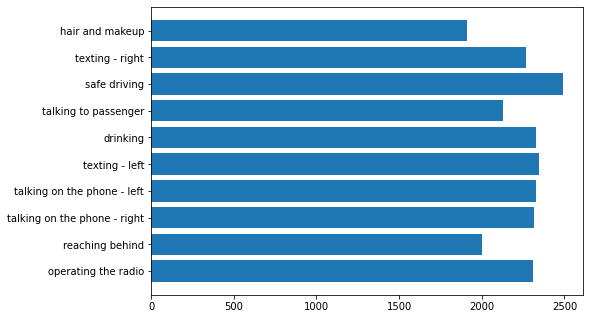

['c5', 'c7', 'c2', 'c4', 'c3', 'c6', 'c9', 'c0', 'c1', 'c8']


In [ ]:
import os
import matplotlib.pyplot as plt

classes_path = '/content/imgs/train/'
classes=os.listdir(classes_path)
images_per_class = [] #number of images per each class
for Class in classes:
    images_path = os.listdir(classes_path+Class)
    images_per_class.append(len(images_path))
    
names_dict = { "c0": "safe driving",
"c1": "texting - right",
"c2": "talking on the phone - right",
"c3": "texting - left",
"c4": "talking on the phone - left",
"c5": "operating the radio",
"c6": "drinking",
"c7": "reaching behind",
"c8": "hair and makeup",
"c9": "talking to passenger" }

classes_names = []
for Class in classes:
    classes_names.append(names_dict[Class]) #convert symbols to names
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(classes_names,images_per_class)
plt.show()
print(classes)

**Train-Validation Split**

In [ ]:
import cv2

Images_set = []

for i in range(10):
    target_class = "c"+str(i)
    images_path = os.path.join(classes_path,target_class)
    images = os.listdir(images_path)
    
    for image in images:
        image_name = os.path.join(images_path,image)
        image_ = cv2.imread(image_name)
        image_ = cv2.resize(image_,(224,224))
        label = i
        Images_set.append([image_,label])
        
print("The number of images in the Images_Set {}".format(len(Images_set)))    

The number of images in the Images_Set 22424


In [ ]:
import random
random.shuffle(Images_set)
split = int(0.8*len(Images_set))

In [ ]:
train_set = Images_set[0:split]
valid_set = Images_set[split:]

In [ ]:
X_train = []
Y_train = []
X_valid = []
Y_valid = []

for image,label in train_set:
    X_train.append(image)
    Y_train.append(label)
for image,label in valid_set:
    X_valid.append(image)
    Y_valid.append(label)

In [ ]:
print("X_train = {}".format(len(X_train)),"  Y_train = {}".format(len(Y_train)))
print("X_valid = {}".format(len(X_valid)),"  Y_valid = {}".format(len(Y_valid)))

X_train = 17939   Y_train = 17939
X_valid = 4485   Y_valid = 4485


Text(0.5, 1.0, 'talking on the phone - left')

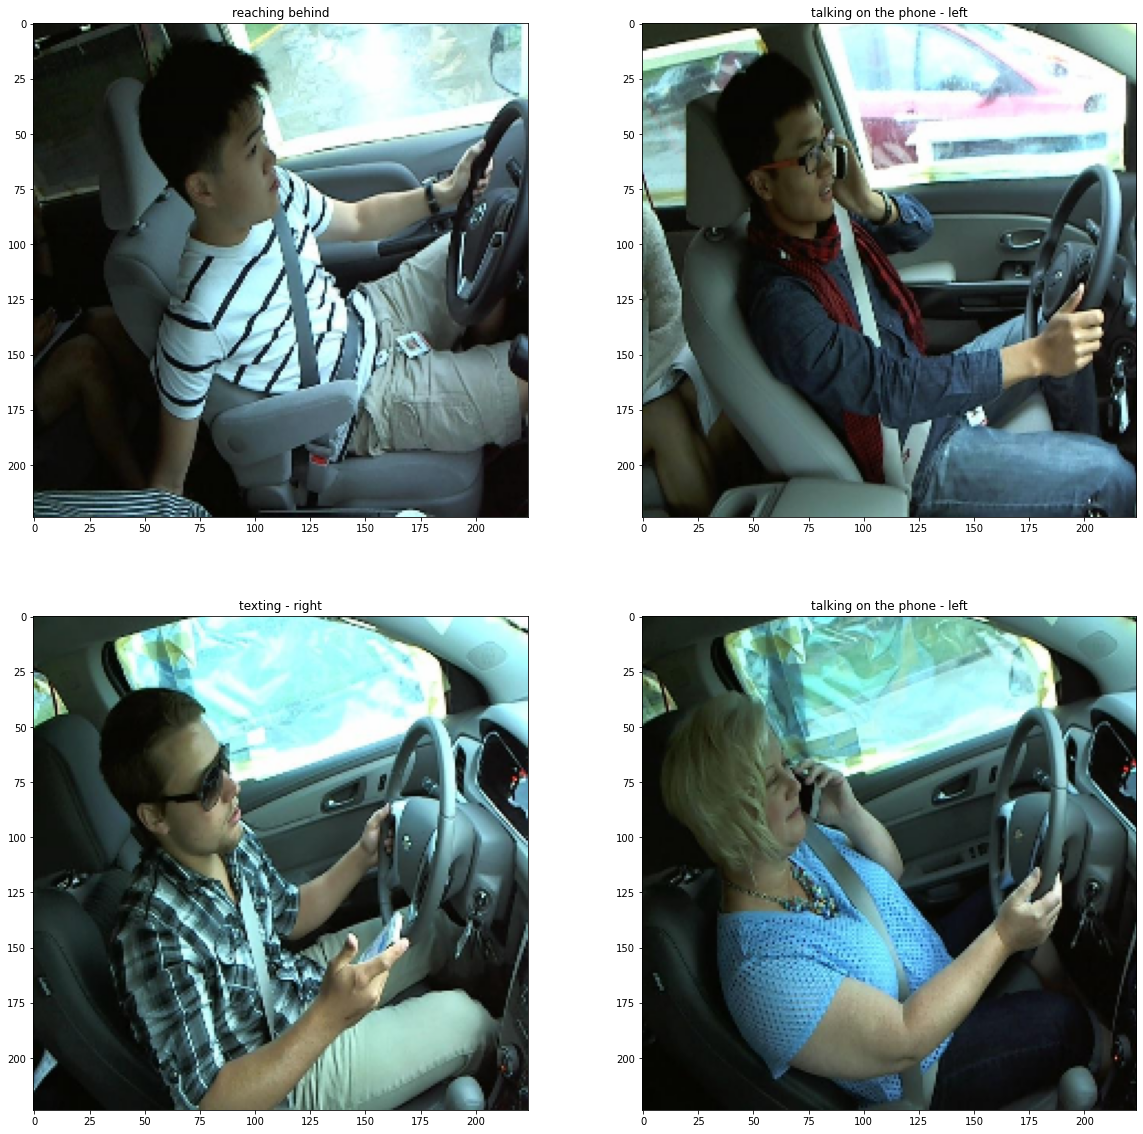

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(20, 20))
axs[0, 0].imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
axs[0, 0].set_title(names_dict["c"+str(Y_train[0])])
axs[0, 1].imshow(cv2.cvtColor(X_train[1], cv2.COLOR_BGR2RGB))
axs[0, 1].set_title(names_dict["c"+str(Y_train[1])])
axs[1, 0].imshow(cv2.cvtColor(X_train[2], cv2.COLOR_BGR2RGB))
axs[1, 0].set_title(names_dict["c"+str(Y_train[2])])
axs[1, 1].imshow(cv2.cvtColor(X_train[3], cv2.COLOR_BGR2RGB))
axs[1, 1].set_title(names_dict["c"+str(Y_train[3])])

**Load and fine tune ResNet50**

In [ ]:
import keras
from keras.utils import to_categorical
import numpy as np

**Decode the images set and the labels**

In [ ]:
X_train = np.array(X_train).reshape(-1,224,224,3)
X_valid = np.array(X_valid).reshape(-1,224,224,3)
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)

In [ ]:
print("X_train = {}".format((X_train.shape)),"  Y_train = {}".format((Y_train.shape)))
print("X_valid = {}".format((X_valid.shape)),"  Y_valid = {}".format((Y_valid.shape)))

X_train = (17939, 224, 224, 3)   Y_train = (17939, 10)
X_valid = (4485, 224, 224, 3)   Y_valid = (4485, 10)


**Load conv layers of the ResNet50 and add sequential layers**

In [3]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense


resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')
output_resnet50_conv = resnet50_conv(resnet50_input)

x = Flatten(name='flatten')(output_resnet50_conv)
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_tuned = Model(inputs = resnet50_input, outputs = x)
resnet50_tuned.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1003530   
Total params: 24,591,242
Trainable params: 24,538,122
Non-trainable params: 53,120
_________________________________________________________________


**compile the model using stochastic gradient descent and cross entropy loss**

In [ ]:
resnet50_tuned.compile(optimizer=keras.optimizers.SGD(lr = 0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

**Trained the model for 40 epoch and batch_size=8**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('driver_resnet_weights_sgd.hdf5', verbose=1, save_best_only=True)
#traingen = ImageDataGenerator(height_shift_range=0.5,width_shift_range = 0.5,zoom_range = 0.5,rotation_range=30)
#train_generator = traingen.flow(X_train,Y_train,batch_size=8)

history = resnet50_tuned.fit(x=X_train,y=Y_train,steps_per_epoch=16,batch_size=8,callbacks=[checkpoint],epochs=40,verbose=1,validation_data=(X_valid,Y_valid))

Epoch 1/40
16/16 [==============================] - 56s 1s/step - loss: 7.6100 - accuracy: 0.1634 - val_loss: 5.9767 - val_accuracy: 0.2725

Epoch 00001: val_loss improved from inf to 5.97675, saving model to driver_resnet_weights_sgd.hdf5
Epoch 2/40
16/16 [==============================] - 17s 1s/step - loss: 5.8514 - accuracy: 0.3636 - val_loss: 13.1349 - val_accuracy: 0.1389

Epoch 00002: val_loss did not improve from 5.97675
Epoch 3/40
16/16 [==============================] - 17s 1s/step - loss: 3.0404 - accuracy: 0.5003 - val_loss: 5.1262 - val_accuracy: 0.4241

Epoch 00003: val_loss improved from 5.97675 to 5.12620, saving model to driver_resnet_weights_sgd.hdf5
Epoch 4/40
16/16 [==============================] - 18s 1s/step - loss: 2.6158 - accuracy: 0.6570 - val_loss: 3.2984 - val_accuracy: 0.6183

Epoch 00004: val_loss improved from 5.12620 to 3.29836, saving model to driver_resnet_weights_sgd.hdf5
Epoch 5/40
16/16 [==============================] - 18s 1s/step - loss: 2.5988 

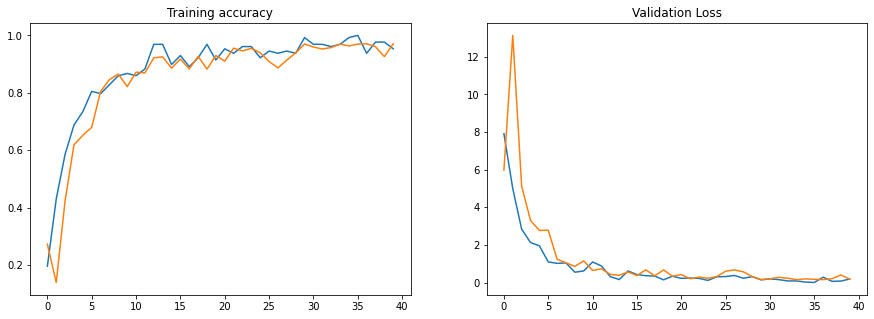

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training accuracy')
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

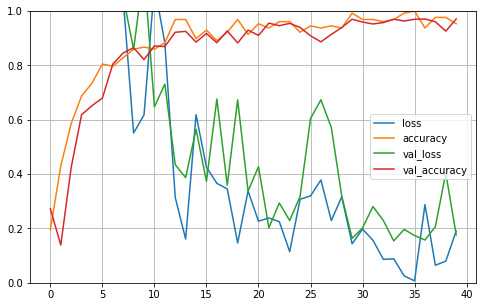

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

**Test**

In [4]:
resnet50_tuned.load_weights('driver_resnet_weights_sgd.hdf5')

In [15]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

test_images = []
test_images_path = '/content/imgs/test'
all_test_images = os.listdir(test_images_path)
random.shuffle(all_test_images)

In [16]:
for i in range(50):
  test_image_name = os.path.join(test_images_path,all_test_images[i])
  image = cv2.imread(test_image_name)
  image = cv2.resize(image,(224,224))
  test_images.append(image)

In [17]:
test_images = np.array(test_images).reshape(-1,224,224,3)

In [18]:
predictions = resnet50_tuned.predict(test_images)

In [20]:
names_dict = { "c0": "safe driving",
"c1": "texting - right",
"c2": "talking on the phone - right",
"c3": "texting - left",
"c4": "talking on the phone - left",
"c5": "operating the radio",
"c6": "drinking",
"c7": "reaching behind",
"c8": "hair and makeup",
"c9": "talking to passenger" }

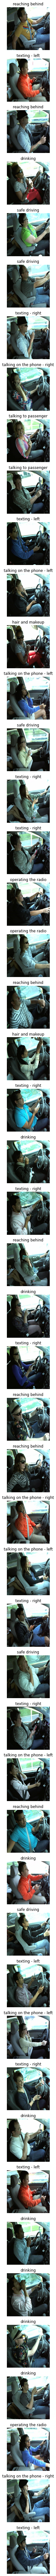

In [26]:
fig, ax = plt.subplots(50, 1, figsize = (150,150))
for i in range(50):
    ax[i].imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))
    predicted_class = (np.where(predictions[i] == np.amax(predictions[i]))[0][0])
    ax[i].set_title(names_dict["c"+str(predicted_class)])
    ax[i].axis('off')
    plt.show
    